In [45]:
import numpy as np
import scipy as sp
import skimage as ski
import skimage.feature
import sklearn as skl
from PIL import Image 
import matplotlib.pyplot as plt
from tqdm import tqdm

In [4]:
cloth_full = Image.open('input/tex1-4k.jpg')
cloth_full.size

(8160, 6144)

In [12]:
texx_color = [Image.open(f'input/tex1-4k_{n}.jpg') for n in range(1,5)]
list(i.size for i in texx)

[(2589, 1949), (2626, 1977), (2274, 1712), (2199, 1656)]

In [41]:
# to greyscale using L channel of Lab representation. Range [0,100]
texx = [(ski.color.rgb2lab(tex)[:,:,0] * 255 / 100).astype(np.uint8) for tex in texx_color]
assert texx[0].shape == (texx_color[0].size[1], texx_color[0].size[0])

In [65]:
texx_thumb = [ skimage.transform.rescale(tex, 1/4, anti_aliasing=True) for tex in texx ]

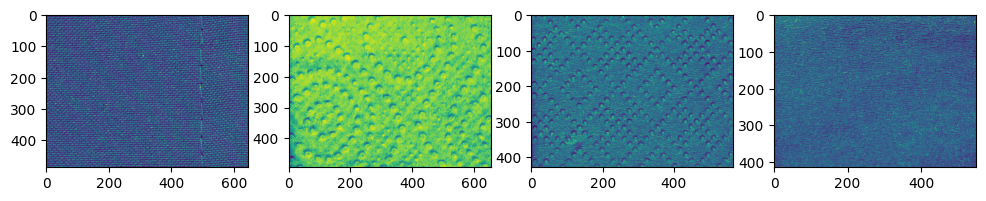

In [66]:
fig, axs = plt.subplots(1,len(texx_thumb))
fig.set_size_inches((12,3))
[ax.imshow(tex) for tex,ax in zip(texx_thumb,axs)]

In [79]:
%%time
lbp_params = [(1,8), (3,24), (5,36)]
lbps = [
    [ski.feature.local_binary_pattern(tex, P, R, 'uniform').astype(np.uint8) for (R,P) in tqdm(lbp_params)] for tex in tqdm(texx)
]
assert len(lbps) == len(texx)
assert len(lbps[0]) == len(lbp_params)

100%|██████████| 4/4 [00:29<00:00,  7.36s/it]

CPU times: total: 28.3 s
Wall time: 29.5 s


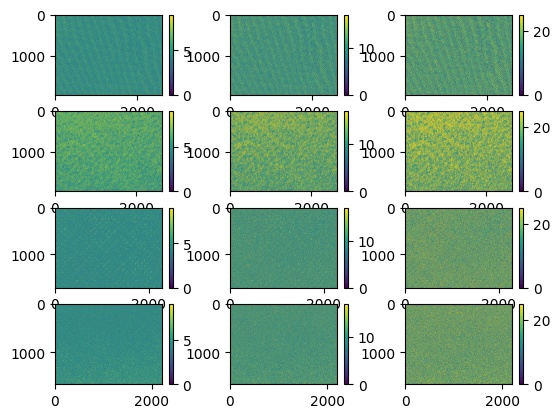

In [ ]:
# fig, axs = plt.subplots(len(texx), len(lbp_params))
# for texlbps,axrow in zip(lbps,axs):
#     for texlbp,ax in zip(texlbps,axrow):
#         i = ax.imshow(texlbp)
#         fig.colorbar(i,ax=ax)


In [80]:
lbps[0][0].dtype

dtype('uint8')

In [81]:
lbphs = [
    [np.bincount(texlbp.flat, minlength=P+2) for texlbp,(R,P) in tqdm(zip(texlbps, lbp_params))] 
    for texlbps in tqdm(lbps)
]

3it [00:00, 32.42it/s]00:00<?, ?it/s]
3it [00:00, 30.19it/s]
3it [00:00, 35.41it/s]00:00<00:00, 10.06it/s]
3it [00:00, 46.90it/s]
100%|██████████| 4/4 [00:00<00:00, 11.27it/s]


In [82]:
for texlbphs, texn in zip(lbphs, range(0,100)):
    for texlbph, (R,P) in zip(texlbphs,lbp_params):
        print(f"tex{texn} {R=} {P=:2}: {(texlbph[-1]/texlbph.sum())*100:6.2f}% nonuniform")

tex0 R=1 P= 8:   3.22% nonuniform
tex0 R=3 P=24:  15.07% nonuniform
tex0 R=5 P=36:  26.19% nonuniform
tex1 R=1 P= 8:   6.20% nonuniform
tex1 R=3 P=24:  31.13% nonuniform
tex1 R=5 P=36:  44.23% nonuniform
tex2 R=1 P= 8:   2.83% nonuniform
tex2 R=3 P=24:  19.87% nonuniform
tex2 R=5 P=36:  40.95% nonuniform
tex3 R=1 P= 8:   2.99% nonuniform
tex3 R=3 P=24:  20.67% nonuniform
tex3 R=5 P=36:  42.28% nonuniform


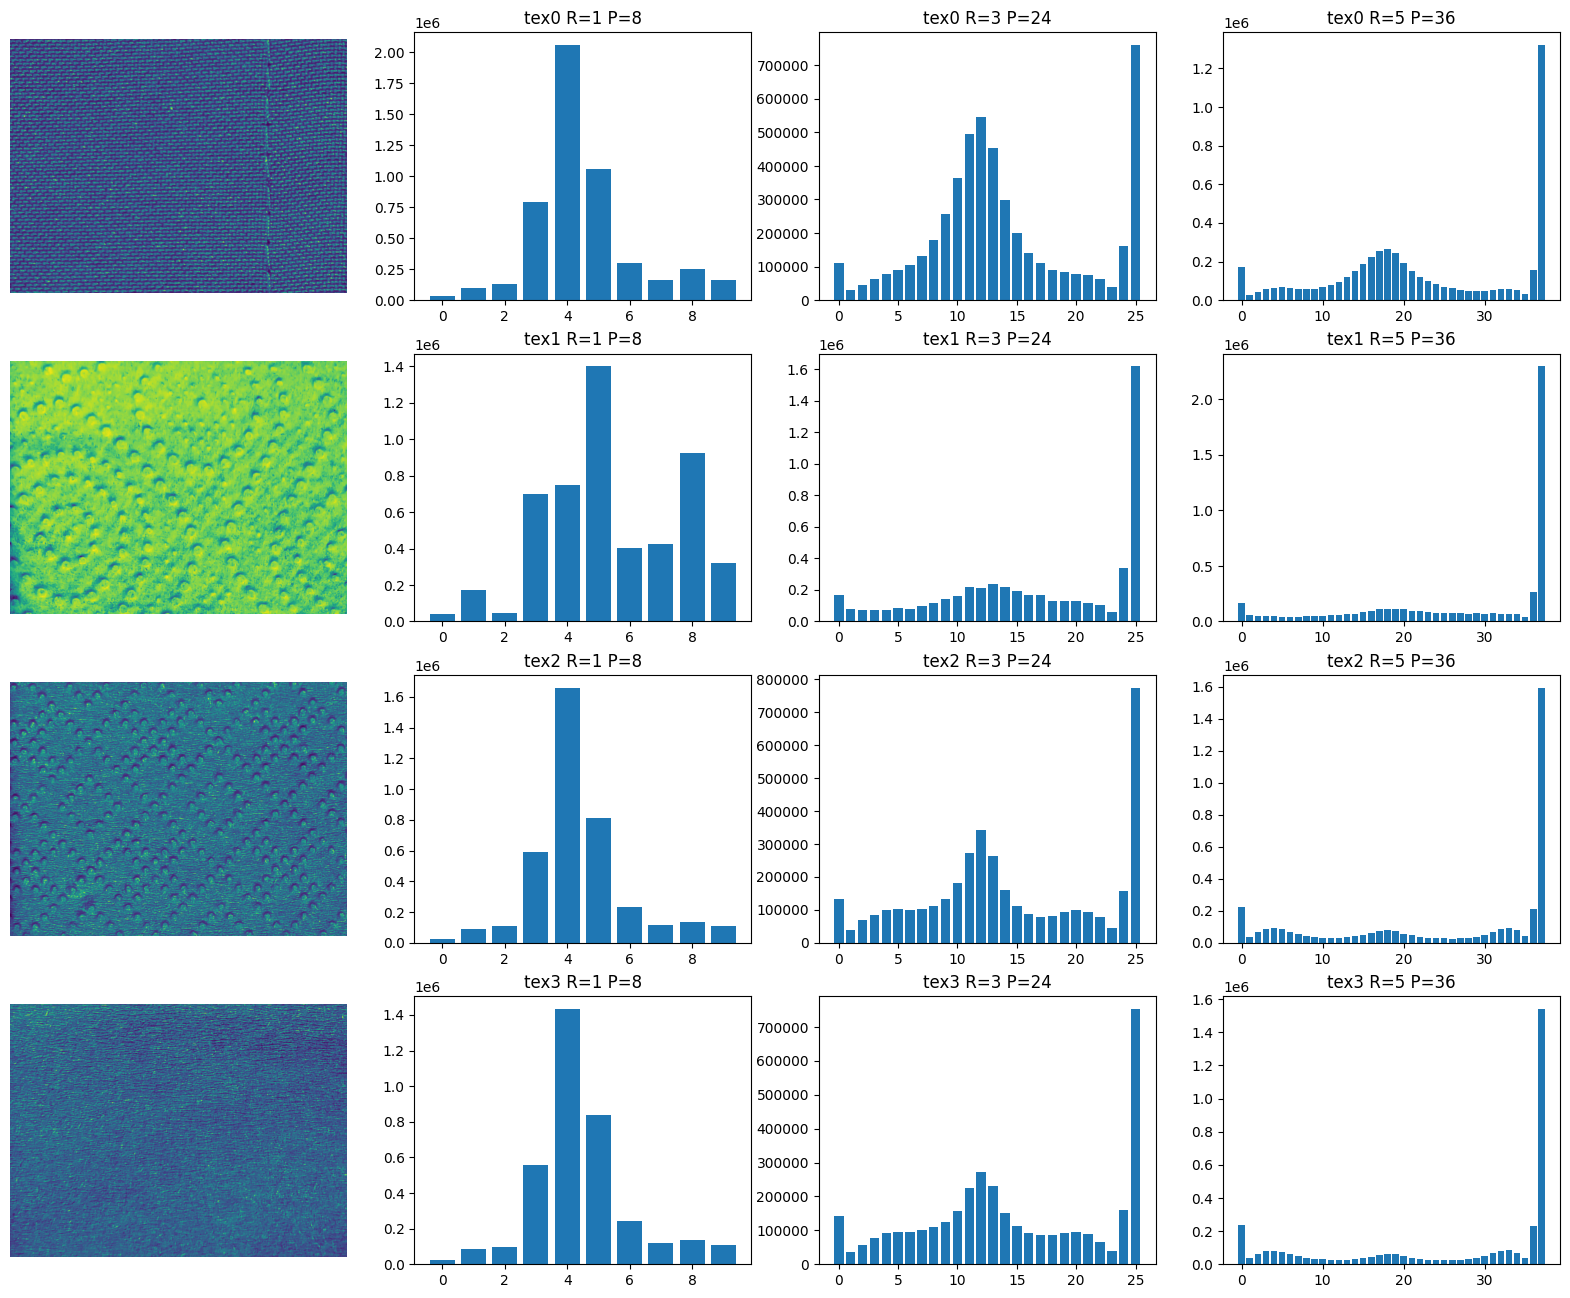

In [87]:
fig, axs = plt.subplots(len(texx_thumb),len(lbp_params) + 1)
for axrow, texlbphs, texn in zip(axs, lbphs, range(0,100)):
    ax = axrow[0]
    ax.imshow(texx_thumb[texn]), ax.set_axis_off()
    for ax, texlbph, (R,P) in zip(axrow[1:],texlbphs,lbp_params):
        ax.bar(np.arange(0,P+2), texlbph)
        ax.set_title(f"tex{texn} {R=} {P=}")
fig.set_size_inches(20,16)
fig.savefig('cloth-hist.jpg', dpi=100)

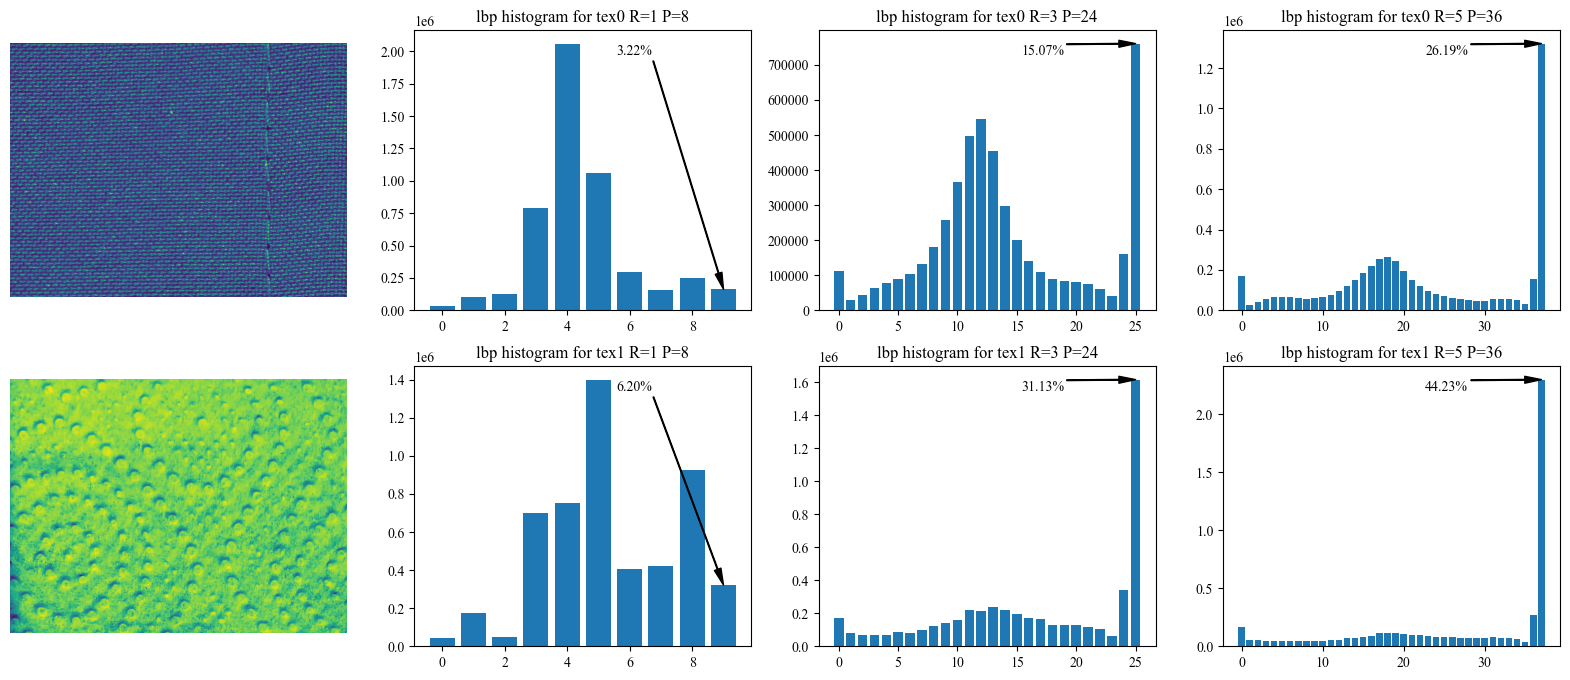

In [118]:
# For thesis
plt.rcParams['font.family'] = 'Times New Roman'
fig, axs = plt.subplots(2,4)
for axrow, texlbphs, texn in zip(axs, lbphs[:2], range(0,100)):
    ax = axrow[0]
    ax.imshow(texx_thumb[texn]), ax.set_axis_off()
    for ax, texlbph, (R,P) in zip(axrow[1:],texlbphs,lbp_params):
        ax.bar(np.arange(0,P+2), texlbph)
        # ax.text((P+1)*0.925, texlbph[-1]*1.005, f"{100*texlbph[-1]/texlbph.sum():.2f}%")
        ax.annotate(
            f"{100*texlbph[-1]/texlbph.sum():.2f}%", 
            xy=(P+1, texlbph[-1]), xycoords='data',
            xytext=(0.6, 0.95), textcoords='axes fraction',
            va='top', ha='left',
            arrowprops=dict(facecolor='black', width=0.5, headwidth=5)
        )
        ax.set_title(f"lbp histogram for tex{texn} {R=} {P=}")
fig.set_size_inches(20,8)
fig.savefig('cloth-hist.jpg', dpi=150, bbox_inches='tight')